# Measuring SN Distances

This is a short tutorial on how to measure supernova (SN) distances with sncosmo.  We'll start with a single Cepheid calibrator SN from a recent Hubble Space Telescope program, SN 2007A in galaxy NGC 105.  Here's what the HST image of NGC 105 looks like:

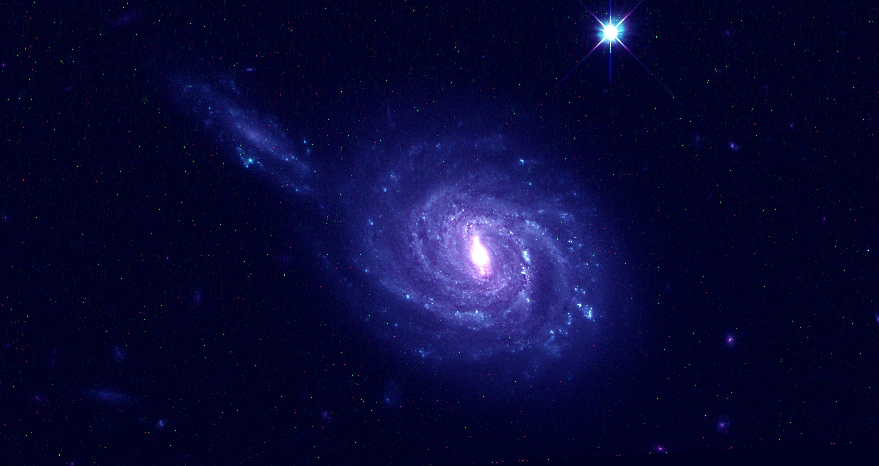

In [1]:
from IPython.display import Image
Image("_static/n105_hst.png")

## Preliminaries

In [62]:
# preliminaries
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import sncosmo # we'll use this to get SN distances
import snana # we'll use this to read supernova light curve files
from astropy.io import fits
import astropy.units as u
from astropy.table import Table
import gzip
import warnings
import get_vpec

# let's get ready to measure distances relative to
# a cosmological model with H0=70, cosmic matter = 0.3
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(70,0.3)

With the imports out of the way - use pip or conda to install anything you're missing - let's grab the SN data.  Most publicly available supernova data are provided through a supernova software called "SNANA".  You'll want to install this eventually, but it's annoying.  For now, go to https://snana.uchicago.edu/downloads.php and download SNDATA_ROOT.tar.gz.  Make a directory called SNDATA_ROOT and copy the .tar.gz file into that directory.  At the command line, run "tar -xvzf SNDATA_ROOT.tar.gz".  Finally, add the directory to your bash profile with emacs ~/.bash_profile .  Add the line

export SNDATA_ROOT = your_install_directory/SNDATA_ROOT

Then open a new bash session and check that it all works by typing

cd $SNDATA_ROOT

You should have changed to the directory that you just created

## Grabbing and Inspecting the SN Data

Supernova light curve files live in the $SNDATA_ROOT/lcmerge directory.  We'll be starting with SN 2007A and as you can see, there are a bunch of different versions:

ls $SNDATA_ROOT/lcmerge/\*/\*2007A\*

From experience, let's use these two:

\\$SNDATA_ROOT/lcmerge/CSPDR3/CSPDR3_2007A.DAT.gz

\\$SNDATA_ROOT/lcmerge/Pantheon_LOWZ_TEXT/CFA4_p1_2007A.dat.gz

Use emacs to take a look at these files.  You'll see some information at the top, including a SN name, coordinates (right ascension and declination), redshift - the recession velocity due to the doppler shift and caused by the expanding universe, and the milky way reddening MWEBV, which is a quantity giving the amount that dust in our own galaxy is expected to make the SN light redder.

Then, lower down in the files, you'll see a list of observations, with each line starting with an "OBS:" key.  For each date a SN was observed, these files give the MJD (modified julian date), the filter in which the SN was observed (aka what color is the light), the magnitude and magnitude uncertainty, and the flux (FLUXCAL) and flux uncertainty (FLUXCALERR).  The relationship between the flux and the magnitude is mag = -2.5\*np.log10(flux)+27.5.

OK, we're ready to take a look at the data!

In [3]:
# first, let's read in a lightcurve file as a python "object"
_snfile = os.path.expandvars("$SNDATA_ROOT/lcmerge/CSPDR3/CSPDR3_2007A.DAT.gz")
sn = snana.SuperNova(_snfile)

In [4]:
# notice how the different quantities in the file are stored as attributes of the object:
print(sn.FLUXCAL) # this prints all the fluxes
print(sn.FLT) # this prints all the filters

[25118.9 26742.4 17298.2 14177.5 11230.5 39373.1 44422.2 46344.7 32991.3
 23922.1 15645.9 45415.1 50164.9 53210.8 48842.7 44957.3 38868.7 29000.1
 26619.5 37085.1 37983.9 36041.3 28840.3 25444.9 21998.9 16795.8 16458.9
 16764.9 17733.7 37119.3 38940.4 41190.8 33822.1 29922.6 26448.4 19301.9
 12752.6 41879.4 46601.5 50442.9 45835.3 43411.  30903.  24434.3 23270.2
 43251.4 43571.2 45123.2 45081.7 40850.7 39664.3 27669.4 28028.5 21537.7
 19934.3 18655.2 17171.2 16641.8 16278.  16188.3 17684.8 20797.  22929.8
 48887.7 47380.5 53161.8 52143.5 37153.5 39120.1 25633.  22824.4 12223.6
 13292.3 39957.7 36408.3 27925.4]
['u' 'u' 'u' 'u' 'u' 'g' 'g' 'g' 'g' 'g' 'g' 'r' 'r' 'r' 'r' 'r' 'r' 'r'
 'r' 'i' 'i' 'i' 'i' 'i' 'i' 'i' 'i' 'i' 'i' 'B' 'B' 'B' 'B' 'B' 'B' 'B'
 'B' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'n' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y'
 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'J' 'J' 'J' 'J' 'J' 'J' 'J' 'J' 'J'
 'J' 'H' 'H' 'H']


One of the annoying things in the format of these data files is that the filter names are assigned randomly in some cases, making it hard to tell what things are.  For that, we need a "kcor" file, which tells us how each filter "letter" corresponds to the different wavelengths of light that are actually contributing to each measurement.  It's not always clear which kcor files are the correct ones, so I'll set up a short dictionary with some of the more useful examples.

In [5]:
# dictionary mapping survey names to kcor files
kcordict = {'CFA4p1':os.path.expandvars('$SNDATA_ROOT/kcor/PS1/Pantheon/kcor_PS1_LOWZ_COMBINED.fits.gz'),
            'CFA4p2':os.path.expandvars('$SNDATA_ROOT/kcor/PS1/Pantheon/kcor_PS1_LOWZ_COMBINED.fits.gz'),
            'CSP':os.path.expandvars('$SNDATA_ROOT/kcor/CSP/CSPDR3/kcor_CSPDR3_BD17.fits.gz')}
kcorfile = kcordict[sn.SURVEY]
kcor = fits.open(kcorfile)
print(kcor[5].data.names)

['wavelength (A)', 'CSP-u', 'CSP-g', 'CSP-r', 'CSP-i', 'CSP-B', 'CSP-V', 'CSP-o', 'CSP-m', 'CSP-n', 'CSP-Y', 'CSP-y', 'CSP-J', 'CSP-j', 'CSP-H', 'CSP-h']


Now, let's take an initial look at the data!

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


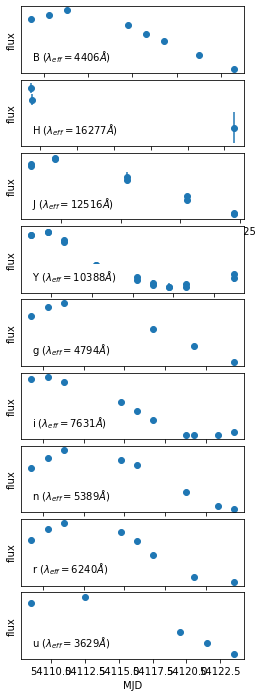

In [6]:
# cosmetic things
plt.rcParams['figure.figsize'] = (4,12)
plt.subplots_adjust(hspace=0.1)

# plot the SN "light curve" for each band
for i,filt in enumerate(np.unique(sn.FLT)):
    # subplot for each filter
    ax = plt.subplot(f"{len(np.unique(sn.FLT))}1{i+1}")
    
    # fluxes and errors
    ax.errorbar(sn.MJD[sn.FLT == filt],sn.FLUXCAL[sn.FLT == filt],yerr=sn.FLUXCALERR[sn.FLT == filt],fmt='o')
    
    # compute the effective wavelength so we know the "color" of each filter
    lameff = np.sum(kcor[5].data[f'CSP-{filt}']*kcor[5].data['wavelength (A)'])/kcor[5].data[f'CSP-{filt}'].sum()
    # using ax.text instead of title makes the spacing better
    ax.text(0.05,0.25,f"{filt} ($\lambda_{{eff}} = {lameff:.0f} \AA$)",ha='left',va='center',transform=ax.transAxes,bbox={'facecolor':'1.0','edgecolor':'1.0'})
    
    # cosmetic stuff
    ax.set_xlabel('MJD')
    ax.set_ylabel('flux')
    ax.set_yticks([]) # absolute flux doesn't matter for now

OK, plot is a bit ugly but you can see we have lots of filters at lots of different wavelengths and data prior to maximum light in some bands.  This means we can probably get a great distance!

# Getting a SN Distance

Now that we've loaded the SN and ensured that the data are ok, we'll want to fit the lightcurve with a SN model.  Our SN model is called "SALT3" (Kenworthy et al. 2021), which is an empirical model that measures three parameters: an amplitude, a shape, and a color.  Those parameters can then be used to measure a distance using the Tripp relation (explained below).

The SALT3 model is implemented in sncosmo, and we can use it to fit our data as follows.  This is a little complicated, and credit to Justin Roberts-Pierel for setting this up in a nice class.  The functions are:

1. get_lc_from_snana_file() - this reads in the data, similarly to what we did above
2. get_filter_info() - this gets the characteristics of the filters through which the SN light was observed
3. setup_salt3_model() - initializes the SALT3 model
4. register_sncosmo_bandpasses() - takes the filter info from step (2) and gives it to sncosmo
5. apply_zpoffs() - offsets in the so-called "zero-point" adjust how bright a SN is in each band.  These photometric system adjustments were determined from analyses that occurred after the original data were taken, and so are kind of a secondary adjustment on top of the original data.

In [44]:
class LC:

    def __init__(self):
        self.lightcurve = None
        self.meta = None
        self.zpoff = None
        self.snsed = None
        self.filtertrans = None
        self.primarysed = None
        self.salt3_model = None
        self.offset_lightcurve = None
    
    # there was a method for this above, but this will read in
    # the lightcurve data
    def get_lc_from_snana_file(self,lc_filename, row_entry_label='OBS'):
        # reading in gzipped files is a little more annoying
        if lc_filename.endswith('.gz'):
            with gzip.open(lc_filename,'rt') as fin:
                meta, tables = sncosmo.read_snana_ascii(fin,default_tablename=row_entry_label)
        else:
            meta, tables = sncosmo.read_snana_ascii(lc_filename,default_tablename=row_entry_label)
        self.lightcurve = tables['OBS']
        self.meta = meta
    
    # filter information - mainly the transmission functions
    def get_filter_info(self,kcor_filename):
        warnings.simplefilter('ignore')
        hdu = fits.open(kcor_filename)
        self.zpoff_tab = Table.read(kcor_filename,format='fits')
        self.zpoff = {row['Filter Name'].strip():{col:row[col] for col in [x for x in self.zpoff_tab.colnames if x!='Filter Name']}\
                     for row in self.zpoff_tab}
        self.snsed = hdu[2].data
        temp_filtertrans = hdu[5].data
        self.filtertrans = {temp_filtertrans.names[i]:np.array([x[i] for x in temp_filtertrans]) for i in range(len(temp_filtertrans.names))}
        self.primarysed = hdu[6].data
        hdu.close()
    
    # now, let's initialize the SALT3 model
    def setup_salt3_model(self,modeldir=None):
        # Milky Way dust
        dust = sncosmo.F99Dust()
        if modeldir is None:
            self.salt3_model = sncosmo.Model('salt3',effects=[dust],effect_names=['mw'],effect_frames=['obs'])
        else:
            self.salt3_model = sncosmo.Model(sncosmo.SALT3Source(modeldir=modeldir),
                                            effects=[dust],effect_names=['mw'],effect_frames=['obs'])
        # we need to know the redshift and the MW dst
        if self.meta is not None:
            if 'REDSHIFT_HELIO' in self.meta.keys():
                self.salt3_model.set(z=self.meta['REDSHIFT_HELIO'])
            if 'MWEBV' in self.meta.keys():
                self.salt3_model.set(mwebv=self.meta['MWEBV'])
            
            
    
    def register_sncosmo_bandpass(self,filtwave,filttrans,filtname,unit=u.angstrom):
        band = sncosmo.Bandpass(filtwave,
                                filttrans,
                                wave_unit=u.angstrom,name=filtname)
        sncosmo.register(band, force=True)
    def apply_zpoffs(self):
        if self.lightcurve is None or self.zpoff is None:
            print("Must read lc and kcor before applying offsets.")
            return
        
        if 'SEARCH_PEAKMJD' in self.meta.keys():
            t0 = self.meta['SEARCH_PEAKMJD']
        else:
            t0 = self.meta['PEAKMJD']
        
        self.offset_lightcurve = Table(rows=None,names=['mjd','band','flux','fluxerr','zp','zpsys'],
                     dtype=('f8','S1','f8','f8','f8','U5'),
                     meta={'t0':t0,'z':self.meta['REDSHIFT_HELIO']})

        for i in range(len(self.lightcurve)):
            m = self.lightcurve['MJD'][i]
            flt = self.lightcurve['FLT'][i]
            if flt in self.zpoff.keys():
                sys = self.zpoff[flt]['Primary Name'].strip()
                fullfilt = flt[:]
            elif flt in [k[-1] for k in self.zpoff.keys()]:
                keys_abbrev = np.array([k[-1] for k in self.zpoff.keys()])
                key = np.array([*self.zpoff.keys()])[keys_abbrev == flt][0]
                sys = self.zpoff[key]['Primary Name'].strip()
                fullfilt = key
            else: continue
            #if sys == 'BD17': sys = 'Vega' # SNANA uses mag of Vega in the BD17 system
            flx = self.lightcurve['FLUXCAL'][i]
            flxe = self.lightcurve['FLUXCALERR'][i]
            self.offset_lightcurve.add_row((m,flt,flx*10**(0.4*self.zpoff[fullfilt]['Primary Mag']),
                              flxe*10**(0.4*self.zpoff[fullfilt]['Primary Mag']),
                              27.5,sys))
        
        filters = np.unique(self.offset_lightcurve['band'])
        for band in filters:
            if band not in self.filtertrans and flt in [k[-1] for k in self.filtertrans.keys()]:
                keys_abbrev = np.array([k[-1] for k in self.filtertrans.keys()])
                fullband = np.array([*self.filtertrans.keys()])[keys_abbrev == band][0]
            else: fullband = band[:]
            self.register_sncosmo_bandpass(self.filtertrans['wavelength (A)'],
                                      self.filtertrans[fullband],
                                      band)
            

Finally, let's write a function to actually fit the data!

In [45]:
flc = LC()
def salt3_lc_fit(flc,lc_filename=None,kcor_filename=None,salt3_directory=None,fit_method='fit_lc'):
        if flc.lightcurve is None:
            if lc_filename is None:
                print('Must read in light first or provide filename.')
                return
            flc.get_lc_from_snana_file(lc_filename)
        if flc.zpoff is None:
            if kcor_filename is None:
                print('Must read in kcor info first or provide filename.')
                return
            flc.get_filter_info(kcor_filename)
        flc.apply_zpoffs()
        if flc.offset_lightcurve is None:
            print('Applying offsets failed.')
            return
        if flc.salt3_model is None:
            flc.setup_salt3_model(salt3_directory)

            
        if fit_method == 'fit_lc':
            res, fit = sncosmo.fit_lc(flc.offset_lightcurve,flc.salt3_model,['t0','x0','x1','c'],
                                      modelcov=True)

        sncosmo.plot_lc(flc.offset_lightcurve,fit,errors=res)
        plt.savefig('fit.png',format='png')
        plt.show()
        
        return res

Now let's initialize the class and use it to measure a distance:

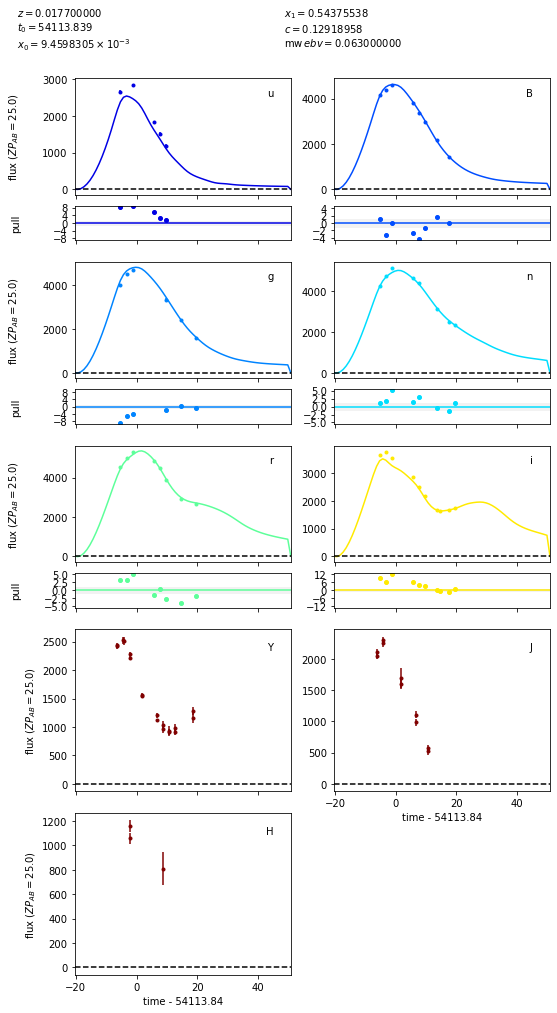

In [46]:
res = salt3_lc_fit(flc,
             lc_filename=os.path.expandvars('$SNDATA_ROOT/lcmerge/CSPDR3/CSPDR3_2007A.DAT.gz'),
             kcor_filename=os.path.expandvars('$SNDATA_ROOT/kcor/CSP/CSPDR3/kcor_CSPDR3_BD17.fits.gz'))

OK!  We've fit our SN data with the model and the bands that were fit look pretty good.  Notice that the data lie pretty close to the model and there's not too much structure in the residuals (the bottom panel).

# Measuring a Distance and Comparing to a Cosmological Distance

Now let's try to get a distance.  The things we'll need are the parameters x0,x1,c.  We'll be computing the distance modulus, $\mu = 5{\rm log_{10}}(d) - 5$ where d is the distance.

In [72]:
x0 = res['parameters'][np.array(res['param_names']) == 'x0'][0]
x1 = res['parameters'][np.array(res['param_names']) == 'x1'][0]
c = res['parameters'][np.array(res['param_names']) == 'c'][0]
print(x0,x1,c)

0.00945983053644269 0.5437553759466566 0.12918958141717785


We determine the distance of the SN by combining x0 (the "amplitude"), x1 (the "shape") and c (the "color") with what's called the Tripp formula (Tripp 1999).  It is extremely simple!

$\mu = -2.5*{\rm log_{10}}(x0) + 10.635 + \alpha\times x_1 - \beta\times c - \mathcal{M}$

$\alpha$ and $\beta$ are coefficients determined from a large SN sample - you will eventually determine those yourself, but for now we'll use fixed values.  $\mathcal{M}$ is a combination of the nominal absolute magnitude of a SN Ia and the value of the Hubble constant.  If we knew H$_0$ exactly, it would be the absolute magnitude of a SN Ia in the $B$ band (a "blue" filter).  We'll set it to -19.36 from convention - it's just a constant, and it won't matter for us.  The number 10.635 I've hardcoded - it's an arbitrary number that reflects the meaning of "amplitude" x0 in the SALT3 model.

In [57]:
salt2alpha = 0.14
salt2beta = 3.1
mu = -2.5*np.log10(x0) + 10.635 + salt2alpha*x1 - salt2beta*c + 19.635
print(f"mu = {mu:.3f} mag")

mu = 35.006 mag


We also need the uncertainty on the distance modulus and there are covariances between these x0,x1,c parameters.  Neglecting the covariance for now, you can figure this out from uncertainty propagation.

In [56]:
muerr = np.sqrt((2.5/np.log(10)*res['errors']['x0']/x0)**2.+ 
                salt2alpha**2. * res['errors']['x1']**2. + 
                salt2beta**2. * res['errors']['c']**2.)
print(f"mu_err = {muerr:.3f} mag")

mu_err = 0.049 mag


Last but not least, we need to compare this to what we'd expect from our cosmological model at a given redshift.  First, that means we need to convert from the heliocentric redshift and correct for peculiar velocities (um I'll write up what's happening here later, sorry...).

Then, we take a predicted distance modulus from the FlatLambdaCDM module we imported at the very top, and:

In [74]:
z = res['parameters'][np.array(res['param_names']) == 'z'][0]

# convert to CMB redshift and apply peculiar velocities
vpec_mapfile_default = os.path.expandvars('$SNDATA_ROOT/models/VPEC/twomass++_velocity_LH11.npy')
vc = get_vpec.VelocityCorrection(vpec_mapfile_default)
zcmb = vc.convert_helio_to_cmb(float(sn.RA.split()[0]),float(sn.DEC.split()[0]),z)
vpec,vsys = get_vpec.main(float(sn.RA.split()[0]),float(sn.DEC.split()[0]),zcmb,vpec_mapfile=vpec_mapfile_default)
# we'll use vpec later, omitted for now

print(f"cosmological distance is {cosmo.distmod(zcmb).value:.3f} mag")
print(vpec)
print(z)

cosmological distance is 34.277 mag
-156.07540154741818
0.0177


OK!  We now have all the pieces in place - the first analysis step will be writing a code to repeat this for all ~9 SNe in our "Cepheid calibrator" sample and plot their distances.